<a href="https://colab.research.google.com/github/viniciusrpb/cloud_image_classification/blob/main/cloud_classification_swimcat_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloud Image Classification using Vision Transformers

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!cp -r "/content/drive/My Drive/img_satelite/classificacao/SWIMCAT/train" "training"
#!cp -r "/content/drive/My Drive/img_satelite/classificacao/SWIMCAT/val" "validation"
#!cp -r "/content/drive/My Drive/img_satelite/classificacao/SWIMCAT/test" "testing"

In [3]:
#!pip install pytorch pytorch torchvision
#!pip install timm==0.3.2
#!pip install datasets transformers
#!pip install transformers pytorch-lightning --quiet
#!sudo apt -qq install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-d3_y987d/pytorch_c7f8f2a3ab4447f78768483e4ba5a416/setup.py'"'"'; __file__='"'"'/tmp/pip-install-d3_y987d/pytorch_c7f8f2a3ab4447f78768483e4ba5a416/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-camf35yo/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pytorch Check the logs f

In [4]:
from datasets import load_dataset
import tensorflow as tf
import torchvision
from torchvision.transforms import ToTensor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import glob
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor,ViTForImageClassification,DeiTForImageClassification,BeitForImageClassification,DeiTFeatureExtractor,  BeitFeatureExtractor
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report

In [5]:
path_train = 'training'
path_validation = 'validation'
path_test = 'testing'

Define the image generator objects

In [6]:
train_ds = torchvision.datasets.ImageFolder(path_train, transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder(path_validation, transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder(path_test, transform=ToTensor())

In [7]:
train_ds.classes

['A-sky', 'B-pattern', 'C-thick-dark', 'D-thick-white', 'E-veil']

In [8]:
def fn_collator(batch):
    encodings = feature_extractor([x[0] for x in batch], return_tensors='pt')
    encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
    return encodings 

Pega os códigos das classes do dataset

In [9]:
dic_label2id = {}
dic_id2label = {}
for i, class_name in enumerate(train_ds.classes):
  dic_label2id[class_name] = str(i)
  dic_id2label[str(i)] = class_name

Allocate objects for loading the data using the DataGenerator

In [10]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
bs = 16

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [11]:
import numpy as np
from datasets import load_metric

acc = load_metric("accuracy")
f1score = load_metric("f1",average='micro')
precision = load_metric("precision")
recall = load_metric("recall")

def compute_metrics(p):

    results1 = acc.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)
    results2 = f1score.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids,average='micro')
    results3 = precision.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids,average='micro')
    results4 = recall.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids,average='micro')

    print(results1)

    return {
        "precision": results3,
        "recall": results4,
        "f1": results2,
        "accuracy": results1,
    }

In [12]:
from transformers import ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(train_ds.classes),
    id2label=dic_id2label,
    label2id=dic_label2id)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-clouds",
  per_device_train_batch_size=bs,
  evaluation_strategy="steps",
  num_train_epochs=10,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-5,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=fn_collator,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [15]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 546
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 350


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,0.207000,0.233940,{'precision': 0.9868421052631579},{'recall': 0.9868421052631579},{'f1': 0.9868421052631579},{'accuracy': 0.9868421052631579}
200,0.108200,0.155655,{'precision': 0.9868421052631579},{'recall': 0.9868421052631579},{'f1': 0.9868421052631579},{'accuracy': 0.9868421052631579}
300,0.094500,0.141192,{'precision': 0.9868421052631579},{'recall': 0.9868421052631579},{'f1': 0.9868421052631579},{'accuracy': 0.9868421052631579}


***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Trainer is attempting to log a value of "{'precision': 0.9868421052631579}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9868421052631579}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9868421052631579}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9868421052631579}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'accuracy': 0.9868421052631579}


Saving model checkpoint to ./vit-base-clouds/checkpoint-100
Configuration saved in ./vit-base-clouds/checkpoint-100/config.json
Model weights saved in ./vit-base-clouds/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./vit-base-clouds/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Trainer is attempting to log a value of "{'precision': 0.9868421052631579}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9868421052631579}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9868421052631579}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorr

{'accuracy': 0.9868421052631579}


Saving model checkpoint to ./vit-base-clouds/checkpoint-200
Configuration saved in ./vit-base-clouds/checkpoint-200/config.json
Model weights saved in ./vit-base-clouds/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./vit-base-clouds/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Trainer is attempting to log a value of "{'precision': 0.9868421052631579}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9868421052631579}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9868421052631579}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorr

{'accuracy': 0.9868421052631579}


Saving model checkpoint to ./vit-base-clouds/checkpoint-300
Configuration saved in ./vit-base-clouds/checkpoint-300/config.json
Model weights saved in ./vit-base-clouds/checkpoint-300/pytorch_model.bin
Feature extractor saved in ./vit-base-clouds/checkpoint-300/preprocessor_config.json
Deleting older checkpoint [vit-base-clouds/checkpoint-100] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-clouds/checkpoint-300 (score: 0.1411919891834259).
Saving model checkpoint to ./vit-base-clouds
Configuration saved in ./vit-base-clouds/config.json
Model weights saved in ./vit-base-clouds/pytorch_model.bin
Feature extractor saved in ./vit-base-clouds/preprocessor_config.json


***** train metrics *****
  epoch                    =        10.0
  total_flos               = 394059009GF
  train_loss               =      0.2751
  train_runtime            =  0:02:04.12
  train_samples_per_second =      43.987
  train_steps_per_second   =        2.82


In [16]:
metrics = trainer.evaluate(test_ds)
#trainer.log_metrics("eval", metrics)
#trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 162
  Batch size = 8


Trainer is attempting to log a value of "{'precision': 1.0}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 1.0}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 1.0}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 1.0}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'accuracy': 1.0}


***** Running Prediction *****
  Num examples = 162
  Batch size = 8


{'accuracy': 1.0}


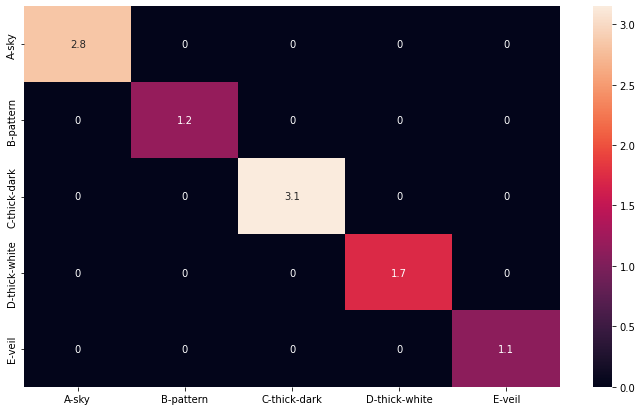

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

testloader = torch.utils.data.DataLoader(test_ds, batch_size=bs,
                                        shuffle=False, num_workers=2)

predictions = trainer.predict(test_ds)

y_prob = predictions[0]

y_pred = np.argmax(y_prob,axis=1)

labels = np.array(predictions.label_ids)
y_true.extend(labels)
     
classes = tuple(test_ds.classes)#('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        #'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
